In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
# Charger les données
file_path = 'Transfert_ new.csv'
transfert_data = pd.read_csv(file_path, sep=';')
transfert_data.columns = transfert_data.columns.str.strip().str.replace('ï»¿', '')

In [6]:
# Convertir la colonne 'dou' en datetime si nécessaire
transfert_data['dou'] = pd.to_datetime(transfert_data['dou'], errors='coerce')

# Ajouter une colonne année et mois
transfert_data['année_mois'] = transfert_data['dou'].dt.to_period('M')

In [7]:
# Calculer la somme des flux par mois
flux_mensuels = transfert_data.groupby('année_mois')['mcfa'].sum().reset_index()
flux_mensuels['année_mois'] = flux_mensuels['année_mois'].dt.to_timestamp()
flux_mensuels = flux_mensuels.rename(columns={'année_mois': 'ds', 'mcfa': 'y'})

In [8]:
# Séparation des données en ensembles d'entraînement et de test
train_size = int(len(flux_mensuels) * 0.8)
train = flux_mensuels[:train_size]
test = flux_mensuels[train_size:]

In [9]:
# Étape 2 : Ajustement du modèle Prophet sur l'ensemble d'entraînement
model = Prophet()
model.fit(train)

# Étape 3 : Faire des prévisions sur l'ensemble de test
future = model.make_future_dataframe(periods=len(test), freq='M')
forecast = model.predict(future)

17:57:57 - cmdstanpy - INFO - Chain [1] start processing
17:57:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [10]:
# Filtrer les prévisions pour la période de test
forecast_test = forecast[['ds', 'yhat']].iloc[-len(test):].reset_index(drop=True)
test = test.reset_index(drop=True)

In [11]:
# Étape 4 : Évaluation des performances
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
mse = mean_squared_error(test['y'], forecast_test['yhat'])
r2 = r2_score(test['y'], forecast_test['yhat'])

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Coefficient of Determination (R²): {r2}')

Mean Absolute Error (MAE): 22753833537.232502
Mean Squared Error (MSE): 6.144641172341887e+20
Coefficient of Determination (R²): -2.3159606237858323


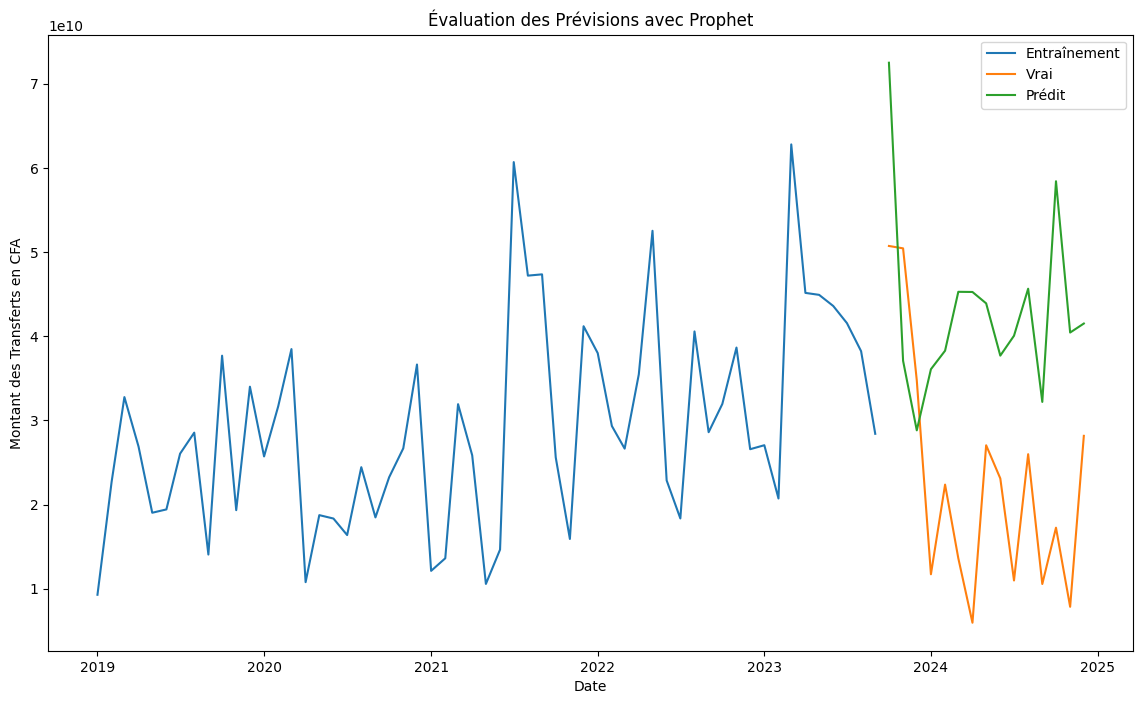

In [12]:
# Étape 5 : Visualisation des résultats
plt.figure(figsize=(14, 8))
plt.plot(train['ds'], train['y'], label='Entraînement')
plt.plot(test['ds'], test['y'], label='Vrai')
plt.plot(test['ds'], forecast_test['yhat'], label='Prédit')
plt.xlabel('Date')
plt.ylabel('Montant des Transferts en CFA')
plt.title('Évaluation des Prévisions avec Prophet')
plt.legend()
plt.show()